# House Price Prediction using XGBoost
## Individual Project
### Data Mining -EC 9560
#### 2021/E/045




In [36]:
from statistics import covariance

from sympy import false
!pip install -r requirements.txt

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


### Import Dataset

In [38]:
datasetPath='./raw/realestate_data_southcarolina_2025.csv'
df=pd.read_csv(datasetPath)
df.head()

,type,sub_type,sqft,baths,beds,stories,year_built,listPrice
0,condos,condo,1268.0,2.0,3.0,1.0,2002.0,199900.0
1,condos,condo,969.0,2.0,2.0,7.0,1985.0,119900.0
2,single_family,NaN,2181.0,3.0,3.0,2.0,NaN,100000.0
3,single_family,NaN,2083.0,2.0,3.0,NaN,1983.0,309900.0
4,land,NaN,NaN,0.0,NaN,NaN,NaN,1000.0


In [39]:

target_col = "listPrice"
df.targetColumn = target_col
y = df[target_col]
X = df.drop(columns=[target_col])


### Basic information


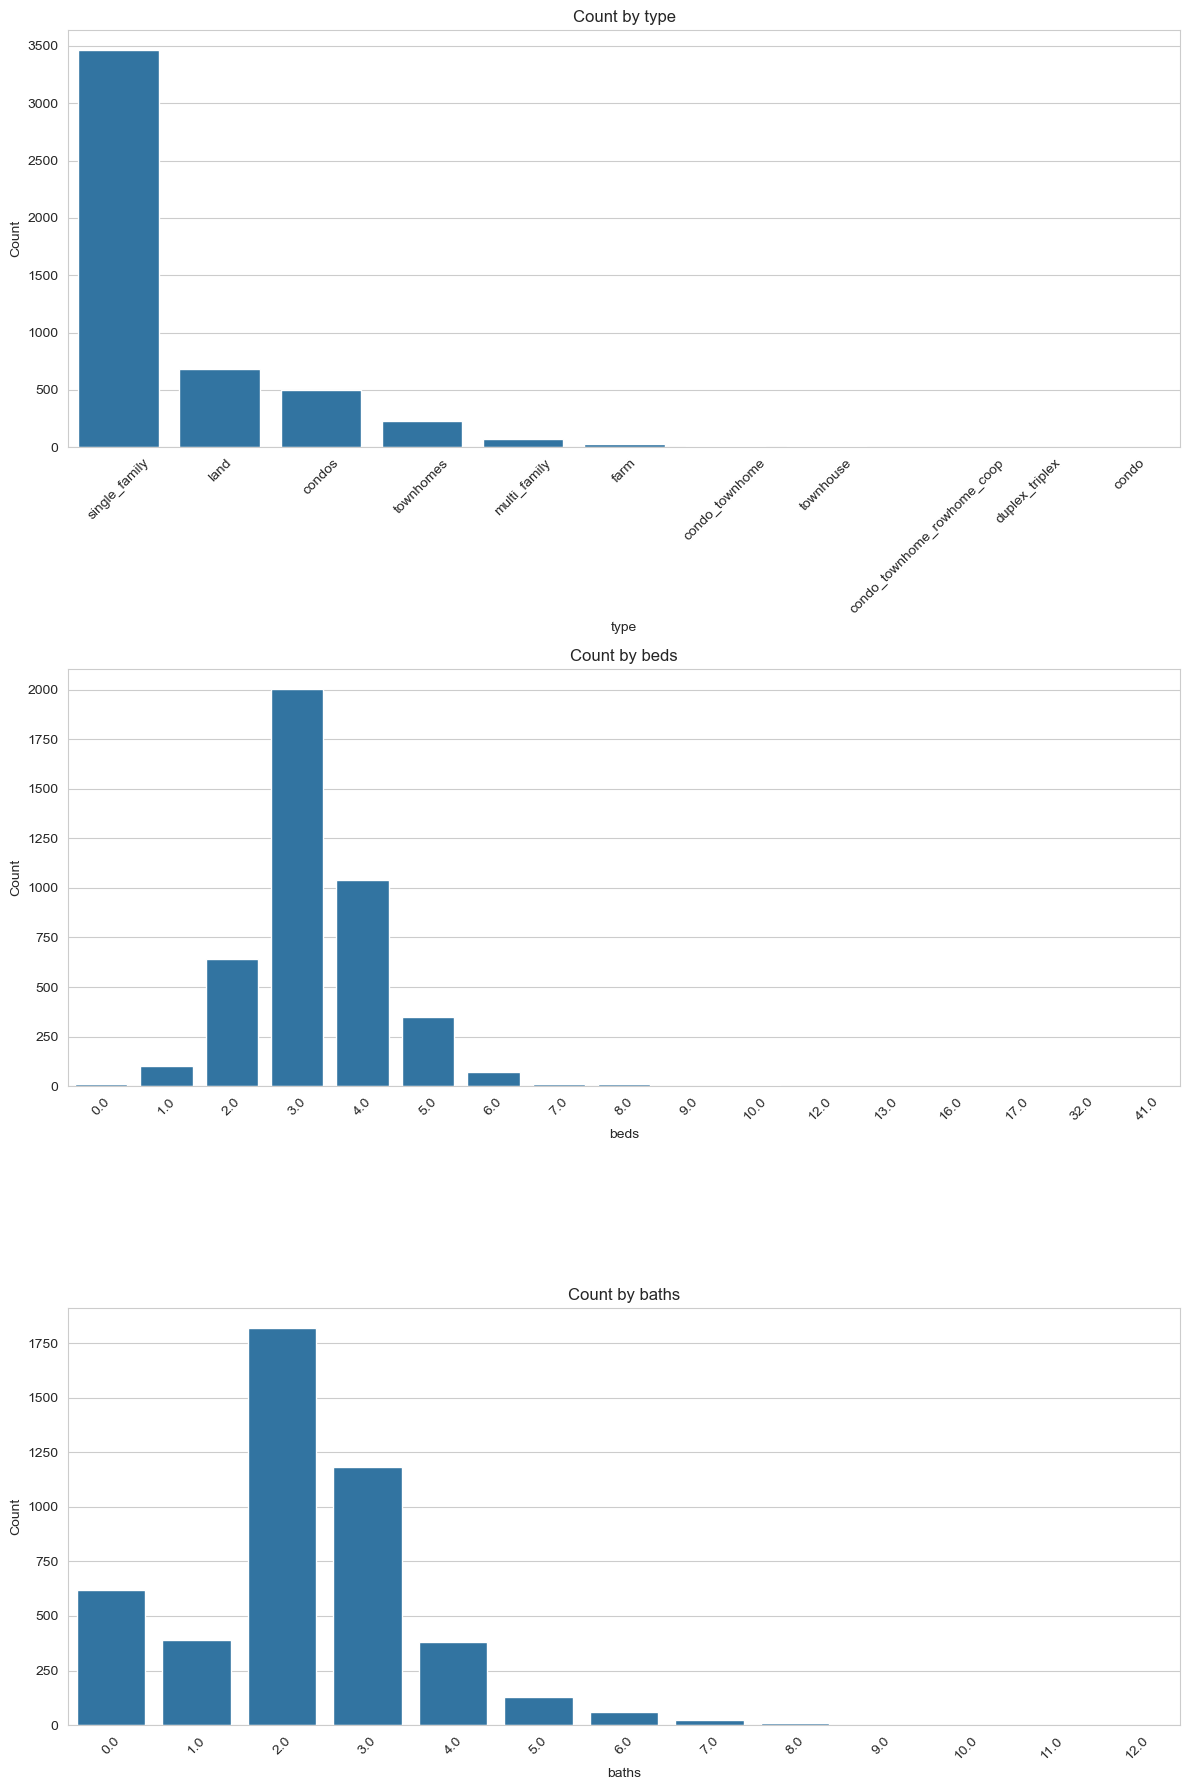

In [40]:

cat_cols = ['type','beds','baths']
plt.figure(figsize=(12,18))
for i, col in enumerate(cat_cols):
    plt.subplot(len(cat_cols), 1, i+1)
    sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts().values)
    plt.title(f'Count by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

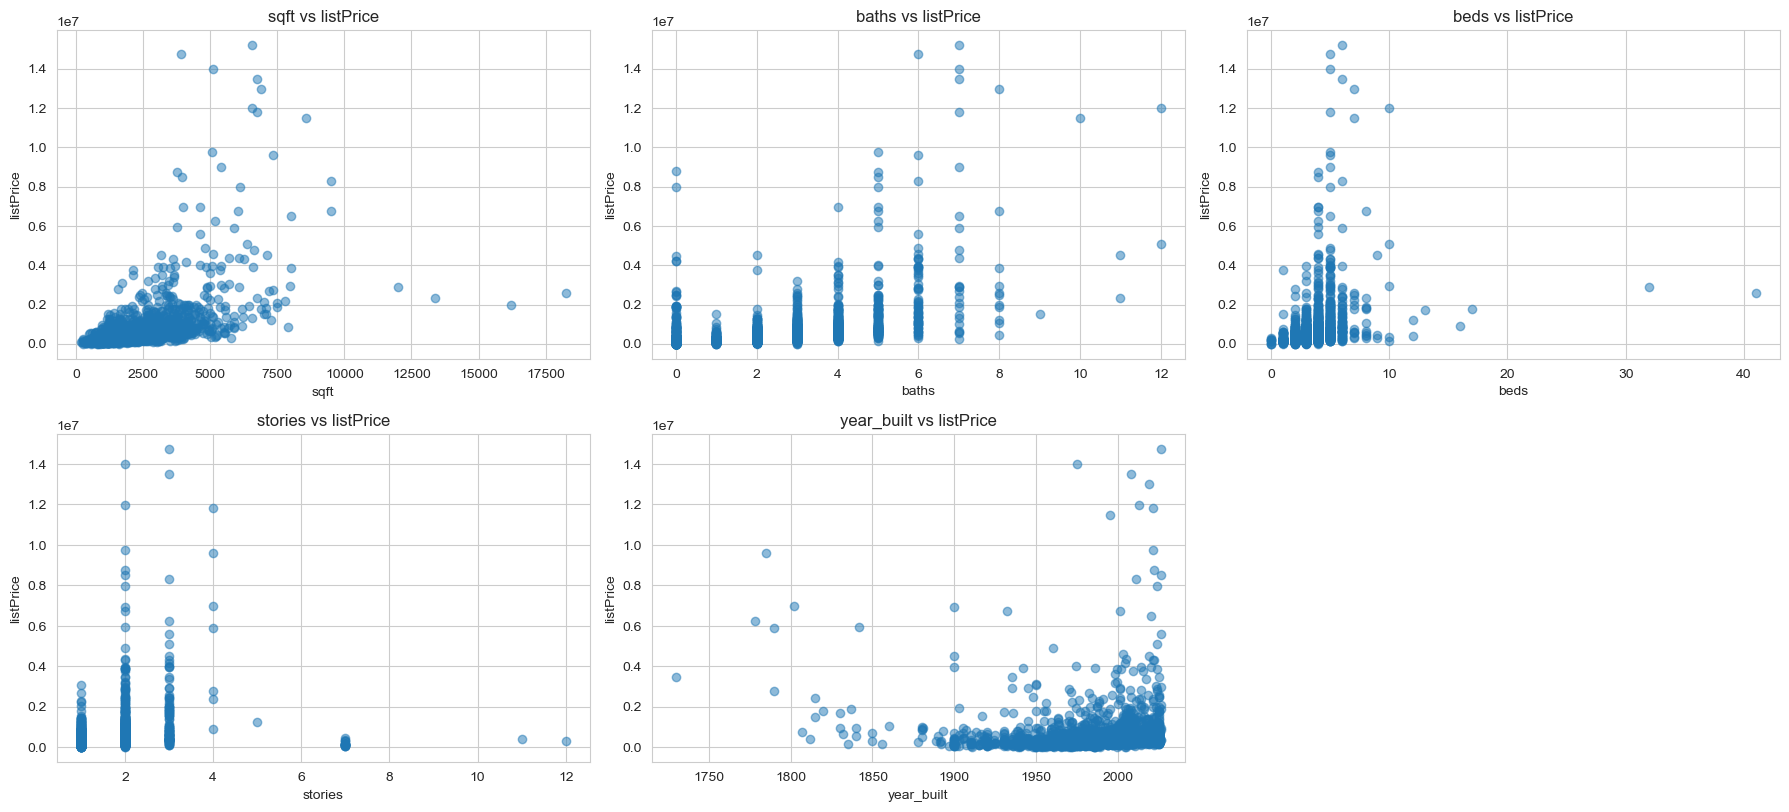

In [41]:
numeric_cols = [col for col in df.select_dtypes(include=['int64','float64']).columns if col!=target_col]
n_cols =3
n_rows =(len(numeric_cols) + n_cols - 1)

plt.figure(figsize=(6*n_cols,4 *n_rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows,n_cols,i + 1)
    plt.scatter(df[col],df[target_col], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.title(f'{col} vs {target_col}')
plt.tight_layout()
plt.show()

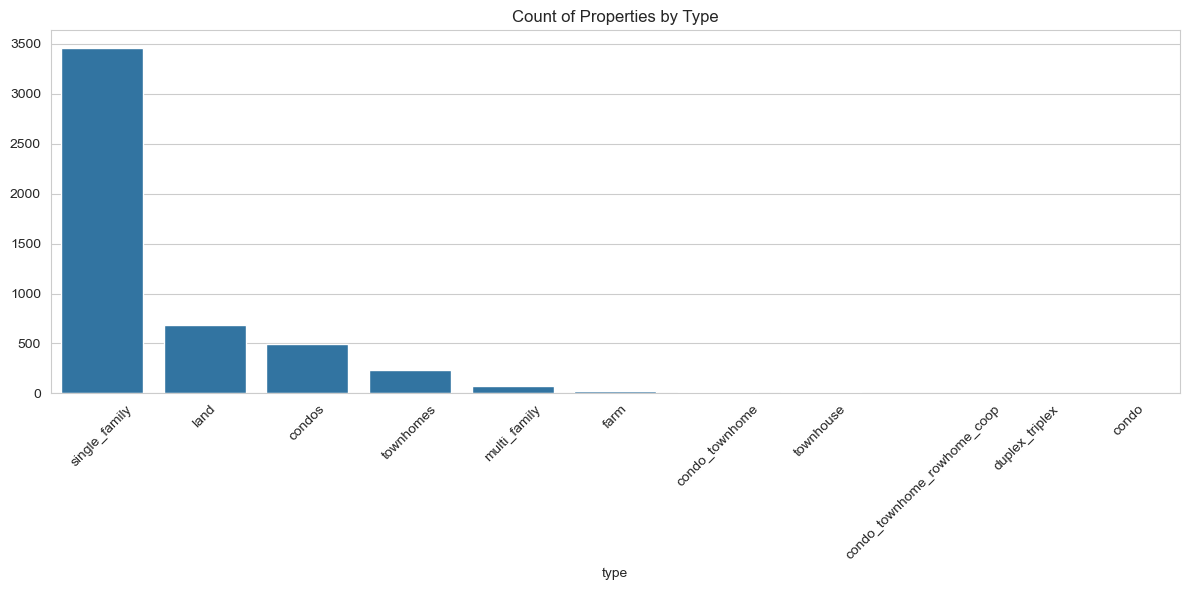

In [42]:
plt.figure(figsize=(12, 6))
sns.barplot(x=df['type'].value_counts().index,
            y=df['type'].value_counts().values)
plt.title('Count of Properties by Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



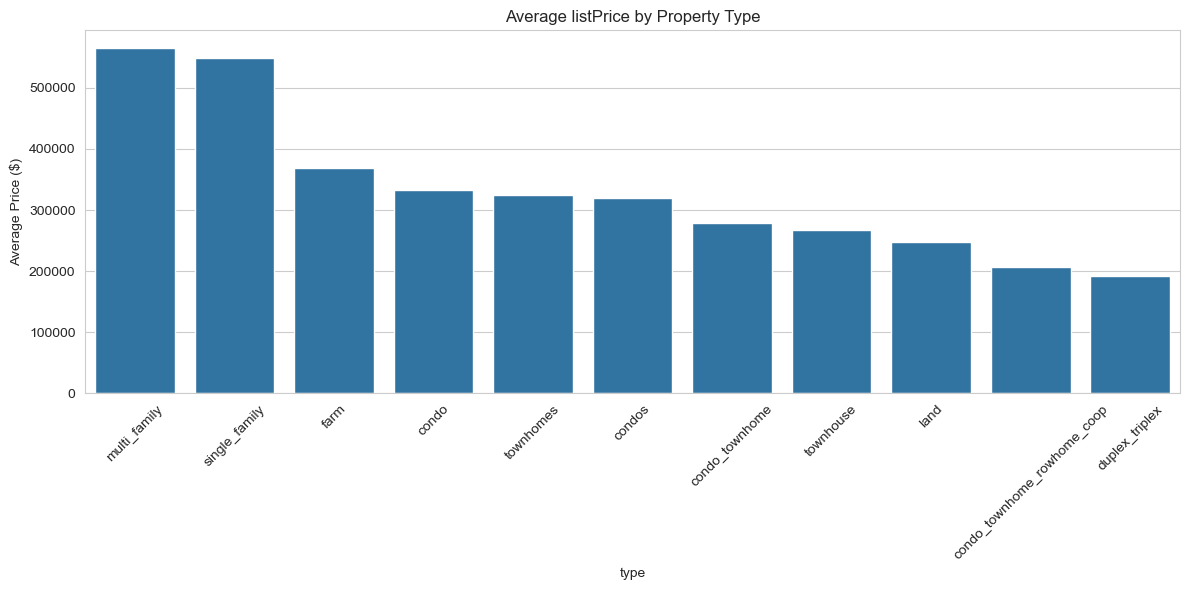

In [43]:
plt.figure(figsize=(12, 6))
avg_price =df.groupby('type')[target_col].mean().sort_values(ascending=False)
sns.barplot(x=avg_price.index, y=avg_price.values)
plt.title(f'Average {target_col} by Property Type')
plt.xticks(rotation=45)
plt.ylabel('Average Price ($)')
plt.tight_layout()
plt.show()


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   type        4998 non-null   object 
 1   sub_type    669 non-null    object 
 2   sqft        4197 non-null   float64
 3   baths       4623 non-null   float64
 4   beds        4250 non-null   float64
 5   stories     3520 non-null   float64
 6   year_built  3379 non-null   float64
 7   listPrice   4973 non-null   float64
dtypes: float64(6), object(2)
memory usage: 312.7+ KB


In [45]:
df.describe()

,sqft,baths,beds,stories,year_built,listPrice
count,4197.000000,4623.000000,4250.000000,3520.000000,3379.000000,4.973000e+03
mean,1997.527043,2.256760,3.316706,1.532386,1988.816514,4.718185e+05
std,1098.871065,1.385171,1.329439,0.740250,30.930078,8.280672e+05
min,182.000000,0.000000,0.000000,1.000000,1730.000000,1.000000e+00
25%,1320.000000,2.000000,3.000000,1.000000,1973.000000,1.999000e+05
50%,1727.000000,2.000000,3.000000,1.000000,1994.000000,3.054000e+05
75%,2400.000000,3.000000,4.000000,2.000000,2010.000000,4.790000e+05
max,18250.000000,12.000000,41.000000,12.000000,2026.000000,1.520000e+07


### Correlation Matrix

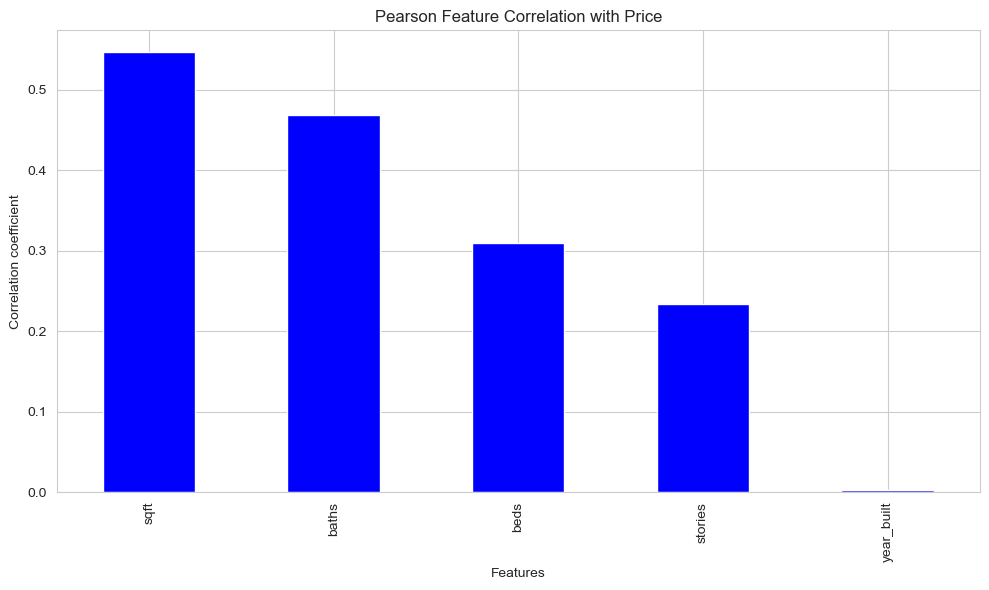

In [46]:

corr_matrix = df.corr(method='pearson',numeric_only=True)

price_corr = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)

plt.figure(figsize=(10,6))
price_corr.plot(kind='bar',color='blue')
plt.title('Pearson Feature Correlation with Price')
plt.ylabel('Correlation coefficient')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

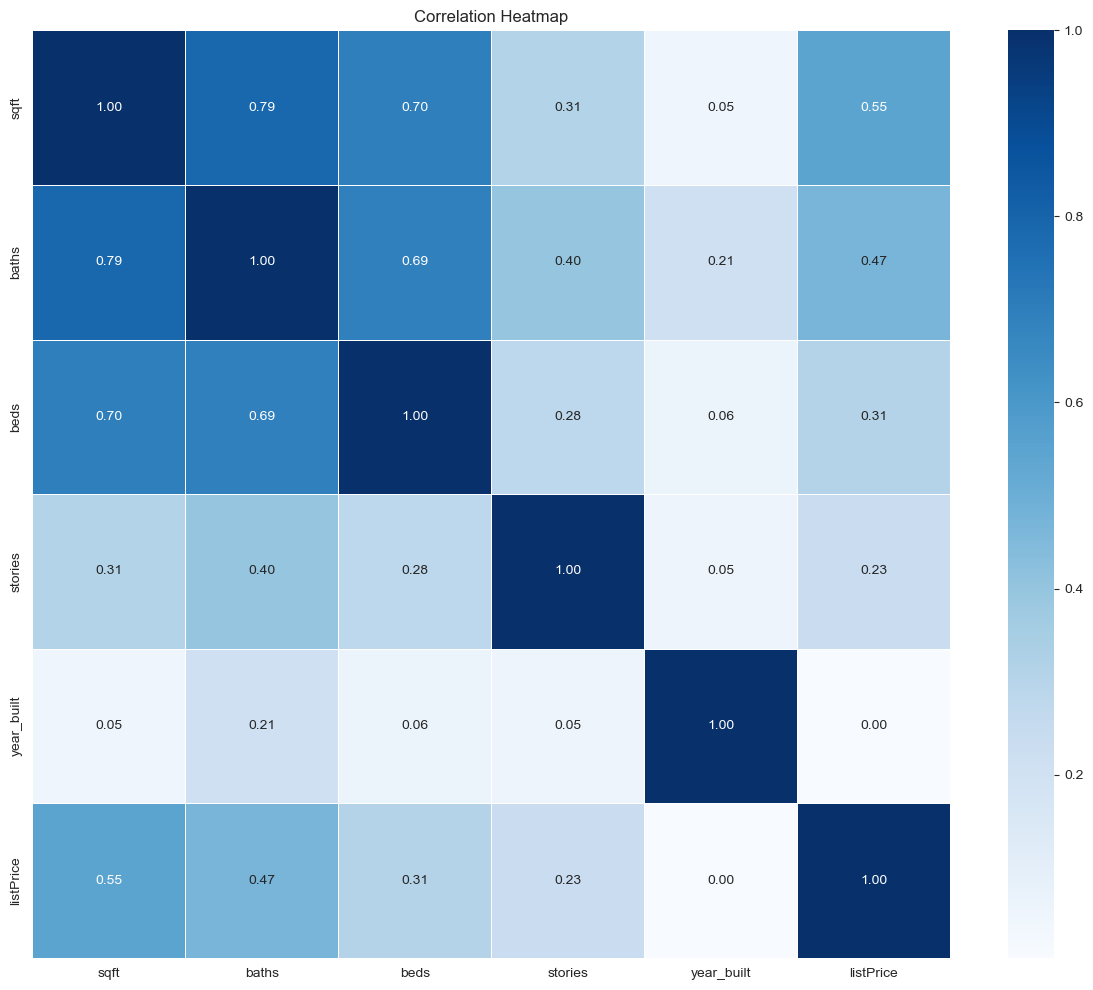

In [47]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,annot=True,cmap='Blues',fmt='.2f',linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

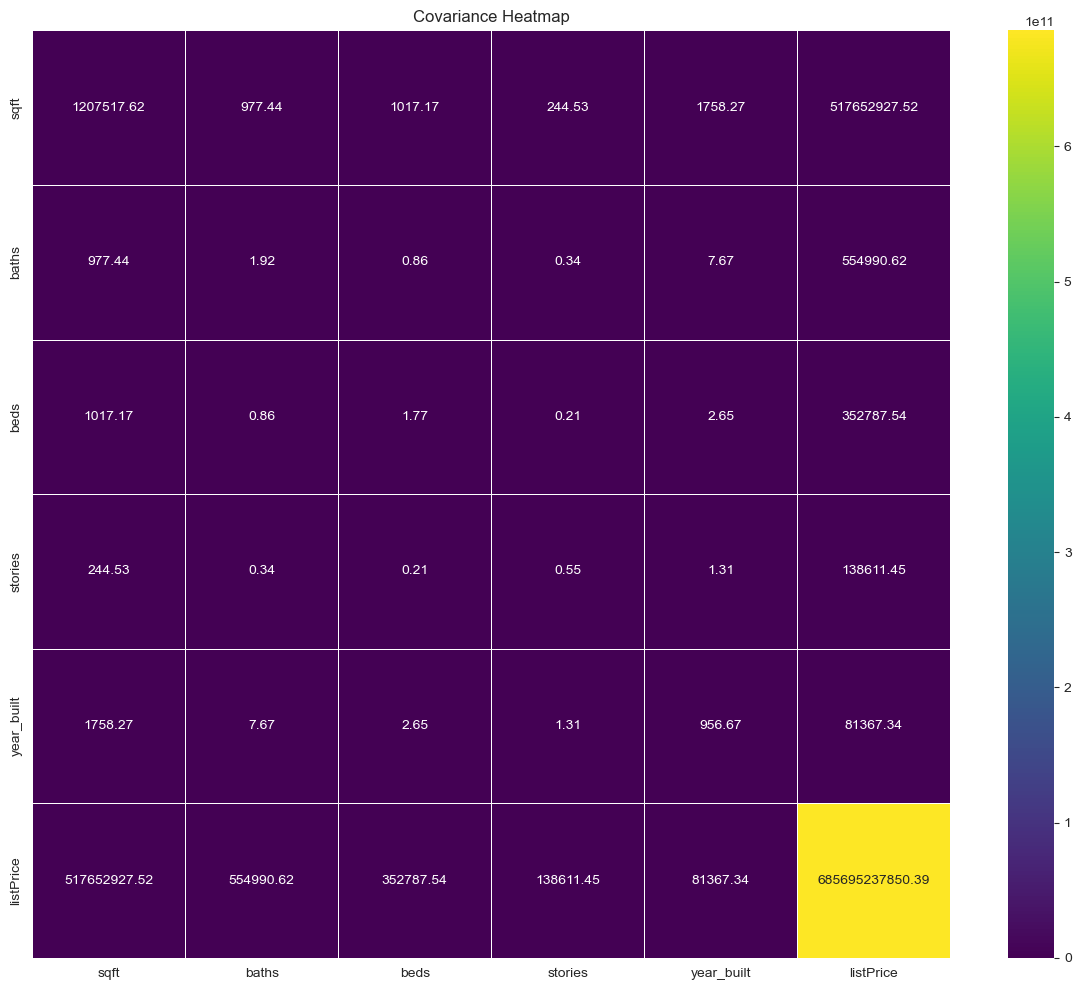

In [48]:
cov_matrix = df.cov(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix,annot=True,cmap='viridis',fmt='.2f',linewidths=0.5)
plt.title('Covariance Heatmap')
plt.tight_layout()
plt.show()

Number of outliers using z-score method: 241


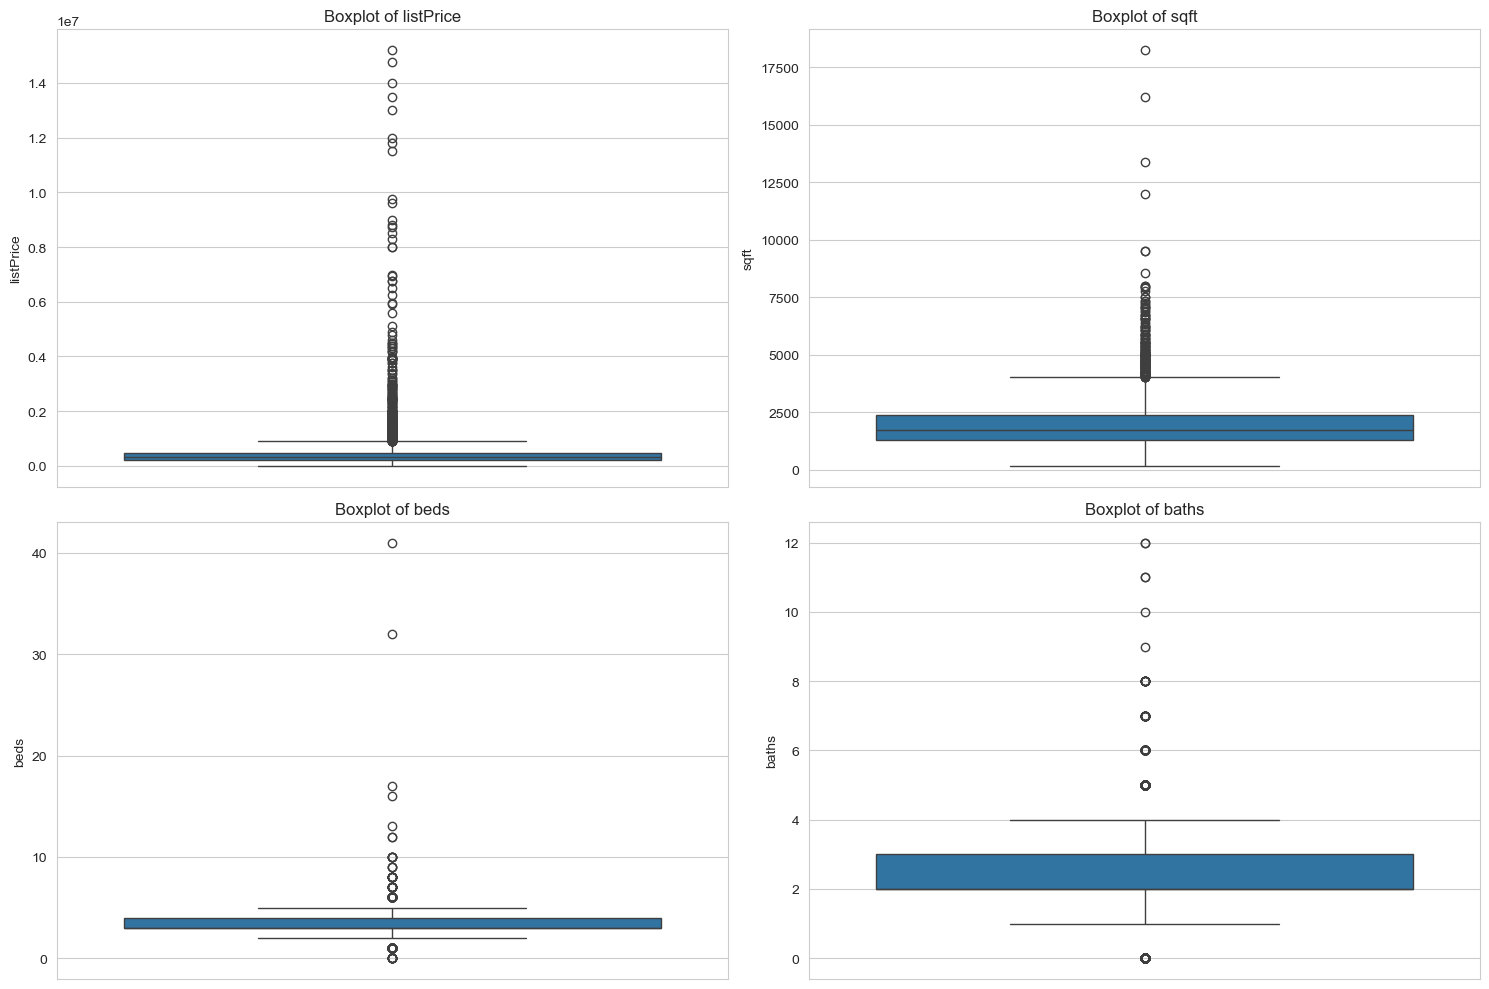

In [53]:
from scipy import stats
numeric_df =df.select_dtypes(include=['int64','float64'])
numeric_df_filled = numeric_df.fillna(numeric_df.mean())
z_scores =stats.zscore(numeric_df_filled)
abs_z_scores= abs(z_scores)
z_outliers =(abs_z_scores >3).any(axis=1)
outliers_z =df[z_outliers]
print(f"Number of outliers using z-score method: {len(outliers_z)}")

plt.figure(figsize=(15,10))
for i, col in enumerate(['listPrice','sqft','beds','baths'][:4]):
    plt.subplot(2,2,i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()